## Note for def seg_disambiguation:
1. if the first/last point of trace is on segmentA, but the rest are on segmentB, then the first point would be mistakenly assigned to segmentB. E.g. test_pts2segs3.geojson; 
    - solution: increase weights(multiple by window_size) to self seg_cands
        - Problem: window_size weights cause jump (test_pts2segs3[22:27])
            - solution: seconde phrase clean use a decrease weight factor=0.5
                - problem: still have jump (test_pts2segs3[22:26])
    - solution2: assign self seg_cands' weight with: window_size * 2 - len(context_left) - len(context_right) + 1
        - Problem: not good enough (test_pts2segs3[22:26] still jump)
            - enhance solution: use clean seg as left context
                - Problem: every point at intersection will be shifted to previous segment(especially when the last points are at intersection)            
2. timestamps helps: test_pts2segs5 is messy without timestamps.
3. random choice of tie seg isn't a good idea, because it's not garunteed that tie segs are one of the turning segs. e.g. test_pts2segs5 snapped.loc[137]
    - Solution: keep tie for the 1st phrase clean up --> it also solve the problem of intersection shifted
        - exception: test_pts2segs5 snapped.loc[83:87], because the orgn pts is messy
4. how to handle snapped points that match no segments(because we could be riding on roads that are not in the segment networks)
5. non-consecutive points will affect the linear reference. 
    - E.g. 
        - test_pts2segs5 on seg_idx=1127 and point_idx=[203,290] (doesn't affect the percentage result)
        - test_pts2segs5 on seg_idx=1175 and point_idx=[212,227] (double the percentage, from 0.5 to 1)
        - test_pts2segs5 on seg_idx=2384/2136 and point_idx=[262, 154]/[273, 165] (falsely increase from 0.8 to 1)
    - solution: 
        - calculate only consecutive points, consecutive is defined by cnsectv_stepsize(e.g. stepsize=3 means [1,2,5] are consecutive while [2,6] aren't)(this stepsize is to handle missing noise points), 
        - and the percentage of the segment should exceed cnsectv_thres(e.g. fraction of 0.05 of a segment is considered as noise)
    

In [1]:

%matplotlib inline
from shapely.geometry import Point, LineString
import geopandas as gp


In [27]:
import trace2segs; reload(trace2segs)
from trace2segs import *
from split_video_gpx import parse_gpx
from snap2road import snap2road
import pandas as pd
from itertools import chain

In [3]:
segs_dc = gp.read_file(u'd:\\★★学习工作\\Life in Maryland\\Research Project：CyclingSafe\\Cycling_safety\\open_data_analysis\\data\\segments_dc.geojson')

In [4]:
segs_dc[['SHAPE_Length','geometry']].apply(lambda x: (x.SHAPE_Length, x.geometry.coords[0][1], x.geometry.coords[0][0], x.geometry.coords[-1][1], x.geometry.coords[-1][0]), axis=1).values

array([ (192.92513149921083, 38.9508361022552, -77.01239193659748, 38.95235086237454, -77.01131698309513),
       (131.93567739730952, 38.95338326885527, -77.01163764014346, 38.954558133776935, -77.01157276320811),
       (117.88701105205183, 38.954558133776935, -77.01157276320811, 38.95561948359257, -77.0116155077942),
       ...,
       (96.52378773507353, 38.87560623506875, -76.99377942384207, 38.875602144914836, -76.9926671133162),
       (53.29620922172282, 38.83621648148795, -77.01960436767503, 38.83583213349032, -77.01997224687713),
       (40.69680807062867, 38.82243956693851, -77.01826374709646, 38.82216947353484, -77.01851803023749)], dtype=object)

In [28]:
import glob
gpxs = glob.glob('Sample Data/GPX/*.gpx')
gpx = 'Sample Data/GPX/Track_2017-02-21 125536.gpx'
gpx = 'Sample Data/GPX/Track_2017-02-21 131933.gpx'

vfile, raw_locs, tms = parse_gpx(gpx)
snapped_res = snap2road(raw_locs,tms)
snapped_df = pd.DataFrame.from_dict(snapped_res['snapped'])
raw_df = pd.DataFrame.from_dict(snapped_res['raw'])
snapped_trace = list(chain(*snapped_df.snapped.values))
snapped_trace_gpdf = gp.GeoDataFrame([Point(x) for x in snapped_trace], columns=['geometry'])
res=trace2segs(segs_dc, snapped_trace, need_snap=False, length_col='SHAPE_Length')
segs_lin=res['segs']



# visualize the trace and corresponding segments


In [28]:
part_segs_dc_plt= segs_dc[['geometry','STREETSEGID']].merge(segs_lin, left_index=True, right_on='index_seg').reset_index()
part_segs_dc_plt['color']='#0a0'

snap_line = gp.GeoDataFrame([LineString(snapped_trace_gpdf.geometry.tolist())], columns=['geometry'])
snap_line['color'] = '#aa0'

snap_pts_gpdf_plt = snapped_trace_gpdf.reset_index()
snap_pts_gpdf_plt['wkt'] = snap_pts_gpdf_plt.geometry.apply(lambda x: x.wkt)
# snap_pts_gpdf_plt.index_ln = snap_pts_gpdf_plt.index_ln.apply(str)
# snap_pts_gpdf_plt.clean_seg = snap_pts_gpdf_plt.clean_seg.apply(str)
# snap_pts_gpdf_plt.clean_seg2 = snap_pts_gpdf_plt.clean_seg2.apply(str)
snap_pts_gpdf_plt.geometry = snap_pts_gpdf_plt.buffer(0.00002)
snap_pts_gpdf_plt['color'] = '#a00'

orgn_pts = gp.GeoDataFrame([Point(x) for x in raw_locs],columns=['geometry'])
orgn_pts_plt = orgn_pts.reset_index()
orgn_pts_plt['wkt'] = orgn_pts_plt.geometry.apply(lambda x: x.wkt)
orgn_pts_plt.geometry = orgn_pts_plt.buffer(0.00002)
orgn_pts_plt['color'] = '#00a'

from leaflet_creation import create_map_visualization

html_title = 'openstreetmap elements'
file_path = ''
file_name = 'vis snap2segs2'
lon, lat = -77.0908494, 38.9045525  #D.C.
zoom = 12
init_layers = ['streets', 'stsg']
map_layers = ['light','streets', 'satellite']
binding_data=[['ly1','snap'],['ly2','orgn'],['ly3', 'segments'],['ly4','snap line']]
gpdfs = [snap_pts_gpdf_plt, orgn_pts_plt, part_segs_dc_plt, snap_line]
create_map_visualization(html_title, file_path, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)

# hand-make-test-data

In [14]:
# facke timestamp
import time
orgn_pts = gp.read_file('hand-make-test-data/test_pts2segs5.geojson')
t = time.time()
tss = [time.strftime('%Y-%m-%dT%H:%M:%SZ',time.gmtime(t+i*5)) for i in range(orgn_pts.shape[0])]
pts_lon_lat = list(orgn_pts.geometry.apply(lambda x: x.coords[0]).values)
segs_for_trace = trace2segs(segs_dc, pts_lon_lat, ())

segs_for_trace 
# for test_pts2segs1: correctly snap regardless the lon confidence
# for test_pts2segs2: seg 884 is the last seg with a few points, covered 10%
# for test_pts2segs3: seg 768 is the first seg with only one point, covered 20%
# for test_pts2segs4: seg 3209 is the last seg
# for test_pts2segs5: seg 2131 is the last seg
# for test_pts2segs6: seg 1052 is the first seg; but we should choose the route wisely, there are may small roads not covered by the segments



# deprecated

## examine trace2segs line by line

[(0, 68, 116, 0.8553247543617214), (1, 68, 100, 0.919279313449731), (2, 68, 91, 0.6664026680287239)]


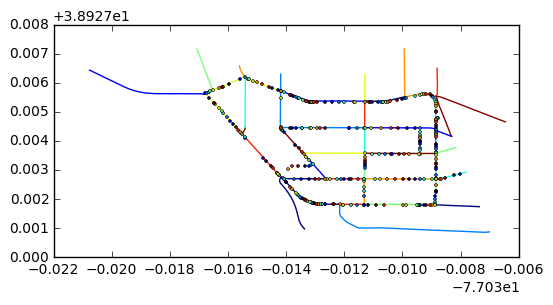

In [90]:
orgn_pts = gp.read_file('test_pts2segs5.geojson')
tss = [time.strftime('%Y-%m-%dT%H:%M:%SZ',time.gmtime(t+i*5)) for i in range(orgn_pts.shape[0])]

return_confidence=True
pts_lon_lat = list(orgn_pts.geometry.apply(lambda x: x.coords[0]).values)

snap_pts = snap2road(pts_lon_lat,tss, return_confidence=return_confidence)

if return_confidence:  # if return_confidence
    snap_pts, confs = snap_pts   
    
snap_pts_gpdf = gp.GeoDataFrame([Point(x) for x in snap_pts],columns=['geometry'])
print confs

pts_segs, pts_no_segs = pts2segs(snap_pts_gpdf, segs_dc, bfr_crs=3559, close_jn_dist=10, far_jn_dist=30)

snap_pts_gpdf = snap_pts_gpdf.merge(
    snap_pts_gpdf.merge(pts_segs, left_index=True, right_on='index_pt').groupby('index_pt')['index_ln'].apply(list).to_frame(), 
    left_index=True, right_index=True, how='left')

for row in snap_pts_gpdf.loc[snap_pts_gpdf.index_ln.isnull(), 'index_ln'].index:
    snap_pts_gpdf.at[row, 'index_ln'] = []

segs_dc.loc[pts_segs.index_ln.value_counts().index.tolist()][['geometry']].append(snap_pts_gpdf).plot()

In [91]:
snap_pts_gpdf['clean_seg']=seg_disambiguation(snap_pts_gpdf.index_ln.values,keep_tie=True)
snap_pts_gpdf['clean_seg2']=seg_disambiguation(snap_pts_gpdf.clean_seg.values)
show_grid(pd.DataFrame(snap_pts_gpdf.iloc[:,1:]))

In [92]:
# linear reference for each segs
from itertools import chain
trace_segs = pd.unique(chain(*snap_pts_gpdf.clean_seg2.values))
print len(trace_segs)
for seg_index in trace_segs:
    seg = segs_dc.loc[seg_index,'geometry']
    projected = snap_pts_gpdf[snap_pts_gpdf.index_ln.apply(lambda x: seg_index in x)].geometry.apply(lambda x: seg.project(x,normalized=True))
    s, e = projected.min(), projected.max()
    round_s, round_e = float_round(s, direction='down'), float_round(e, direction='up')
    print (seg_index, round_s, round_e, round_e - round_s)

25
(2431, 0.0, 1.0, 1.0)
(2432, 0.0, 1.0, 1.0)
(2025, 0.0, 1.0, 1.0)
(2026, 0.0, 1.0, 1.0)
(2190, 0.0, 1.0, 1.0)
(5257, 0.0, 1.0, 1.0)
(5084, 0.0, 1.0, 1.0)
(5083, 0.0, 1.0, 1.0)
(5082, 0.0, 1.0, 1.0)
(935, 0.0, 1.0, 1.0)
(934, 0.0, 1.0, 1.0)
(933, 0.0, 1.0, 1.0)
(932, 0.0, 1.0, 1.0)
(2430, 0.0, 1.0, 1.0)
(1126, 0.0, 1.0, 1.0)
(2133, 0.0, 1.0, 1.0)
(2134, 0.0, 1.0, 1.0)
(1175, 0.0, 1.0, 1.0)
(1050, 0.0, 1.0, 1.0)
(2385, 0.0, 1.0, 1.0)
(2384, 0.0, 1.0, 1.0)
(2136, 0.0, 1.0, 1.0)
(1127, 0.0, 1.0, 1.0)
(2132, 0.0, 1.0, 1.0)
(2131, 0.1, 1.0, 0.9)


In [94]:
import numpy as np
np.where(np.diff(a) != 1)

(array([0, 4], dtype=int64),)

[(-77.0388715736476, 38.928806727412685), (-77.03886989595551, 38.928901225178365), (-77.0388637220345, 38.92925388748542), (-77.03886038897325, 38.929444249439996), (-77.0388571384783, 38.929616849783834), (-77.03885590485244, 38.929681079459), (-77.0388555666682, 38.92969540278752)]
173    1.000000
174    0.998517
175    0.991742
176    0.754312
177    0.529264
178    0.525870
179    0.492122
180    0.350324
181    0.208545
182    0.097120
183    0.021751
184    0.000000
301    0.991742
Name: geometry, dtype: float64
173    1.000000
174    0.998517
175    0.991742
176    0.754312
177    0.529264
178    0.525870
179    0.492122
180    0.350324
181    0.208545
182    0.097120
183    0.021751
184    0.000000
Name: geometry, dtype: float64
(932, 0.0, 1.0) (0.0, 1.0)
301    0.991742
Name: geometry, dtype: float64


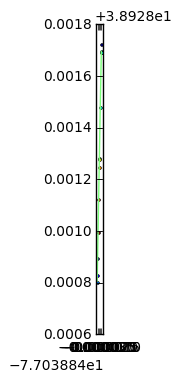

In [111]:
# pick one seg to check the projection
seg_index = 932
print segs_dc.loc[seg_index,'geometry'].coords[:]
snap_pts_gpdf[snap_pts_gpdf.index_ln.apply(lambda x: seg_index in x)].append(segs_dc.loc[seg_index,['geometry']]).plot()

seg = segs_dc.loc[seg_index,'geometry']
projected = snap_pts_gpdf[snap_pts_gpdf.index_ln.apply(lambda x: seg_index in x)].geometry.apply(lambda x: seg.project(x,normalized=True))
print projected
for sub_indices in consecutive(projected.index.values):
    sub = projected[sub_indices]
    print sub
    s, e = sub.min(), sub.max()
    round_s, round_e = float_round(s, direction='down'), float_round(e, direction='up')
    if e-s>0.05:
        print (seg_index, round_s, round_e), (s,e)

In [96]:
# visualize the trace and corresponding segments
part_segs_dc_plt= segs_dc.loc[pts_segs.index_ln.value_counts().index.tolist()][['geometry']].reset_index()
part_segs_dc_plt['color']='#0a0'

snap_line = gp.GeoDataFrame([LineString(snap_pts_gpdf.geometry.tolist())], columns=['geometry'])
snap_line['color'] = '#aa0'

snap_pts_gpdf_plt = snap_pts_gpdf.reset_index()
snap_pts_gpdf_plt['wkt'] = snap_pts_gpdf_plt.geometry.apply(lambda x: x.wkt)
snap_pts_gpdf_plt.index_ln = snap_pts_gpdf_plt.index_ln.apply(str)
snap_pts_gpdf_plt.clean_seg = snap_pts_gpdf_plt.clean_seg.apply(str)
snap_pts_gpdf_plt.clean_seg2 = snap_pts_gpdf_plt.clean_seg2.apply(str)
snap_pts_gpdf_plt.geometry = snap_pts_gpdf_plt.buffer(0.00002)
snap_pts_gpdf_plt['color'] = '#a00'

orgn_pts_plt = orgn_pts.reset_index()
orgn_pts_plt['wkt'] = orgn_pts_plt.geometry.apply(lambda x: x.wkt)
orgn_pts_plt.geometry = orgn_pts_plt.buffer(0.00002)
orgn_pts_plt['color'] = '#00a'

from leaflet_creation import create_map_visualization

html_title = 'openstreetmap elements'
file_path = ''
file_name = 'vis snap2segs'
lon, lat = -77.0908494, 38.9045525  #D.C.
zoom = 12
init_layers = ['streets', 'stsg']
map_layers = ['light','streets', 'satellite']
binding_data=[['ly1','snap'],['ly2','orgn'],['ly3', 'segments'],['ly4','snap line']]
gpdfs = [snap_pts_gpdf_plt, orgn_pts_plt, part_segs_dc_plt, snap_line]
create_map_visualization(html_title, file_path, file_name, lat, lon, zoom, init_layers, map_layers, binding_data, gpdfs)